# Purpose of the project
The goal of the project is to prepare a skull stripping method on T1-type magnetic resonance imaging (MRI) sequences of the head. The method should extract the entire area occupied by the actual brain from the patient's raw scan, omitting bones, other soft tissues, etc. - illustration in the figure below:
![](https://www.researchgate.net/profile/Dario_Pompili/publication/309402865/figure/fig1/AS:420915604148224@1477365508110/Skull-stripping-steps-A-input-images-B-brain-contouring-and-C-removal-of.png)

Below is sample code that downloads, unpacks, and loads data into a `numpy` matrix of three dimensions. In addition, a function is included to visualize the center slice(s) in each of the three axes of the matrix.


# Solution

## Loading data

In [3]:
!pip install --upgrade nibabel

     |████████████████████████████████| 3.3 MB 4.0 MB/s 
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [4]:
!wget "https://putpoznanpl-my.sharepoint.com/:u:/g/personal/dominik_pieczynski_put_poznan_pl/EWIZ_xm8wXpMjQDgF2VQ1csB4QuHPKoj5vDpj6CQi9p-AA?e=yQr6fn&download=1" -O public.zip
!unzip -q public.zip
!rm public.zip

--2022-03-14 17:53:40--  https://putpoznanpl-my.sharepoint.com/:u:/g/personal/dominik_pieczynski_put_poznan_pl/EWIZ_xm8wXpMjQDgF2VQ1csB4QuHPKoj5vDpj6CQi9p-AA?e=yQr6fn&download=1
Resolving putpoznanpl-my.sharepoint.com (putpoznanpl-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to putpoznanpl-my.sharepoint.com (putpoznanpl-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dominik_pieczynski_put_poznan_pl/Documents/Public.zip [following]
--2022-03-14 17:53:42--  https://putpoznanpl-my.sharepoint.com/personal/dominik_pieczynski_put_poznan_pl/Documents/Public.zip
Reusing existing connection to putpoznanpl-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 5672415949 (5.3G) [application/x-zip-compressed]
Saving to: ‘public.zip’

public.zip          100%[===================>]   5.28G  29.9MB/s    in 2m 21s  

2022-03-14 17:56:04 (38.4 MB/s) - ‘public.zip’ saved [5672415949/567241594

In [5]:
!ls FirstDataset/train

011e40c2b1d3c9bb53bd9e5a7efd04ba_mask.nii.gz
011e40c2b1d3c9bb53bd9e5a7efd04ba.nii.gz
0187e4cb2fb4971848c8981e9ece0849_mask.nii.gz
0187e4cb2fb4971848c8981e9ece0849.nii.gz
022161680299e1f3bea7169947dc45b6_mask.nii.gz
022161680299e1f3bea7169947dc45b6.nii.gz
02862555e24fd75a84a3259e4210e73b_mask.nii.gz
02862555e24fd75a84a3259e4210e73b.nii.gz
04e0e6ed0432fd737fd3f29fe551b77c_mask.nii.gz
04e0e6ed0432fd737fd3f29fe551b77c.nii.gz
05b438c4933b77168c529ea19486a1c9_mask.nii.gz
05b438c4933b77168c529ea19486a1c9.nii.gz
06503d8025b2830c50599cfcc0febd39_mask.nii.gz
06503d8025b2830c50599cfcc0febd39.nii.gz
0a2de3cae8ca66ea62b7e2dae3bdffca_mask.nii.gz
0a2de3cae8ca66ea62b7e2dae3bdffca.nii.gz
0b3ea09bb26b17af2b596e96875d2ca2_mask.nii.gz
0b3ea09bb26b17af2b596e96875d2ca2.nii.gz
0c7dc995949da4278941d36c048ff2c9_mask.nii.gz
0c7dc995949da4278941d36c048ff2c9.nii.gz
0efee62646deb97c8c7cfa0f457fa4dc_mask.nii.gz
0efee62646deb97c8c7cfa0f457fa4dc.nii.gz
105625ce5c645192e3c3ca78b7b32edb_mask.nii.gz
105625ce5c645192e3c3

In [6]:
import numpy as np
import nibabel as nib
import cv2
from typing import Tuple, List
from pathlib import Path


def load_raw_volume(path: Path) -> Tuple[np.ndarray, np.ndarray]:
  data: nib.Nifti1Image = nib.load(str(path))
  data = nib.as_closest_canonical(data)
  raw_data = data.get_fdata(caching='unchanged', dtype=np.float32)
  return raw_data, data.affine


def load_labels_volume(path: Path) -> np.ndarray:
  return load_raw_volume(path)[0].astype(np.uint8)


def save_labels(data: np.ndarray, affine: np.ndarray, path: Path):
  nib.save(nib.Nifti1Image(data, affine), str(path))


def show_slices_raw(slices: List[np.ndarray]):
   fig, axes = plt.subplots(1, len(slices))
   for i, data_slice in enumerate(slices):
      axes[i].imshow(data_slice.T, cmap="gray", origin="lower")


def show_slices_mask(slices: List[np.ndarray]):
   fig, axes = plt.subplots(1, len(slices))
   for i, data_slice in enumerate(slices):
       axes[i].imshow(data_slice.T, cmap="gray", origin="lower")

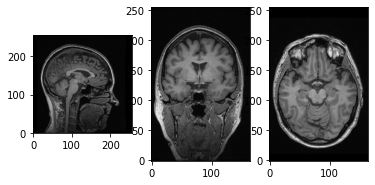

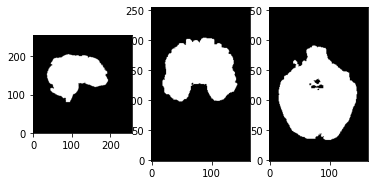

In [7]:
import matplotlib.pyplot as plt

# Zmienna affine zawiera macierz, która będzie potrzebna przy zapisie predykcji do pliku
raw_volume, affine = load_raw_volume('/content/FirstDataset/train/e66ce7e96b277d7d1b8835e5d2c94cd6.nii.gz')
mask_volume = load_labels_volume('/content/FirstDataset/train/e66ce7e96b277d7d1b8835e5d2c94cd6_mask.nii.gz')

show_slices_raw([raw_volume[raw_volume.shape[0] // 2], # Środkowy slice 2D w osi x
             raw_volume[:, raw_volume.shape[1] // 2], # Środkowy slice 2D w osi y
             raw_volume[:, :, raw_volume.shape[2] // 2]]) # Środkowy slice 2D w osi z
             
show_slices_mask([mask_volume[mask_volume.shape[0] // 2], # Środkowy slice 2D w osi x
             mask_volume[:, mask_volume.shape[1] // 2], # Środkowy slice 2D w osi y
             mask_volume[:, :, mask_volume.shape[2] // 2]]) # Środkowy slice 2D w osi z

## EXPORT TO *PNG*

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*CENTRAL* SCANS

In [9]:
!mkdir /content/drive/MyDrive/Dane_ZPO
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/images_x
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/images_y
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/images_z

mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain/images_y’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/Dane_ZPO/proj_brain/images_z’: File exists


In [10]:
from pathlib import Path

pathlist = Path('/content/FirstDataset/train').rglob('*.nii.gz')
dim = ['x', 'y', 'z']
for j, filename in enumerate(pathlist):
  name_raw = filename.name[:-7]
  name_mask = filename.name[:-12]
  print(filename)
  if str(filename)[-11:-7] == 'mask':
    mask_volume = load_labels_volume(filename) # mask files
    for i, d in enumerate(dim):
      if d == 'x':
        slice = mask_volume[mask_volume.shape[i] // 2]
      elif d == 'y':
        slice = mask_volume[:, mask_volume.shape[i] // 2]
      elif d == 'z':
        slice = mask_volume[:, :, mask_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_{d}/{name_mask}_{d}_mask.png', slice.T, cmap="gray", origin="lower")

  else:
    raw_volume, affine = load_raw_volume(filename) # raw files
    for i, d in enumerate(dim):
      if d == 'x':
        slice = raw_volume[raw_volume.shape[i] // 2]
      elif d == 'y':
        slice = raw_volume[:, raw_volume.shape[i] // 2]
      elif d == 'z':
        slice = raw_volume[:, :, raw_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/images_{d}/{name_raw}_{d}.png', slice.T, cmap="gray", origin="lower")

/content/FirstDataset/train/230fc584dd1d830029c2541b92a9d706.nii.gz
/content/FirstDataset/train/14e56328418c740eed3c9dacd5d1b889_mask.nii.gz
/content/FirstDataset/train/46b1cb48fd0adefcdf4cad3821a653ac.nii.gz
/content/FirstDataset/train/91fac31aee832d06eb34764281954b3c.nii.gz
/content/FirstDataset/train/5620f0607730f7fd945e8276b86deade_mask.nii.gz
/content/FirstDataset/train/aa3eab8fa2c04cac7823919753b62f66.nii.gz
/content/FirstDataset/train/6c251e4f25b565b8658587c11f1965e0_mask.nii.gz
/content/FirstDataset/train/b733c96ae9806d2242522a805042c461_mask.nii.gz
/content/FirstDataset/train/60082a68029d76d3e011f91829dae1ac.nii.gz
/content/FirstDataset/train/977cfe9bdcc649bfd2e75e0a8194f057_mask.nii.gz
/content/FirstDataset/train/e2ce5b719c88ac6656aff908870c204b_mask.nii.gz
/content/FirstDataset/train/facc52e047affeb776b57884c8cef041_mask.nii.gz
/content/FirstDataset/train/31a1d5a10bfef78b092fa157a9a57e77_mask.nii.gz
/content/FirstDataset/train/87fcfae6be7a67dffd1dcbff8180a9ee.nii.gz
/content

In [11]:
!ls /content/drive/MyDrive/Dane_ZPO/proj_brain/images_y | wc -l

288


In [12]:
!ls /content/FirstDataset/test | wc -l

72


In [ ]:
pathlist = Path('/content/SecondDataset/train').rglob('*.nii.gz')
for j, filename in enumerate(pathlist):
  name = filename.name[:-7]

  if str(name) == 'mask':
    mask_volume = load_labels_volume(filename) # mask files
    photo_name = str(filename)[29:-12]
    for i, d in enumerate(dim):
      if d == 'x':
        slice = mask_volume[mask_volume.shape[i] // 2]
      elif d == 'y':
        slice = mask_volume[:, mask_volume.shape[i] // 2]
      elif d == 'z':
        slice = mask_volume[:, :, mask_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_{d}/{photo_name}_{d}_mask.png', slice.T, cmap="gray", origin="lower")

  else:
    raw_volume, affine = load_raw_volume(filename) # raw files
    photo_name = str(filename)[29:-11]
    for i, d in enumerate(dim):
      if d == 'x':
        slice = raw_volume[raw_volume.shape[i] // 2]
      elif d == 'y':
        slice = raw_volume[:, raw_volume.shape[i] // 2]
      elif d == 'z':
        slice = raw_volume[:, :, raw_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/images_{d}/{photo_name}_{d}.png', slice.T, cmap="gray", origin="lower")


ALL SCAN LAYERS

In [ ]:
from pathlib import Path

pathlist = Path('/content/FirstDataset/train').rglob('*.nii.gz')
dim = ['x', 'y', 'z']
for j, filename in enumerate(pathlist):
  name_raw = filename.name[:-7]
  name_mask = filename.name[:-12]
  # print(name)
  if str(filename)[-11:-7] == 'mask':
    mask_volume = load_labels_volume(filename) # mask files /content/FirstDataset/train/389c6febb5679a4543a140ced9a9e723_mask.nii.gz
    for i, d in enumerate(dim):
      if d == 'x':
        slice = mask_volume[mask_volume.shape[i] // 2]
      elif d == 'y':
        slice = mask_volume[:, mask_volume.shape[i] // 2]
      elif d == 'z':
        slice = mask_volume[:, :, mask_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_{d}/{name_mask}_{d}_mask.png', slice.T, cmap="gray", origin="lower")

  else:
    raw_volume, affine = load_raw_volume(filename) # raw files
    for i, d in enumerate(dim):
      if d == 'x':
        slice = raw_volume[raw_volume.shape[i] // 2]
      elif d == 'y':
        slice = raw_volume[:, raw_volume.shape[i] // 2]
      elif d == 'z':
        slice = raw_volume[:, :, raw_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/images_{d}/{name_raw}_{d}.png', slice.T, cmap="gray", origin="lower")

In [ ]:
pathlist = Path('/content/SecondDataset/train').rglob('*.nii.gz')
for j, filename in enumerate(pathlist):
  name = filename.name[:-7]
  if str(name) == 'mask':
    mask_volume = load_labels_volume(filename) # mask files
    photo_name = str(filename)[29:-12]
    for i, d in enumerate(dim):
      if d == 'x':
        slice = mask_volume[mask_volume.shape[i] // 2]
      elif d == 'y':
        slice = mask_volume[:, mask_volume.shape[i] // 2]
      elif d == 'z':
        slice = mask_volume[:, :, mask_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_{d}/{photo_name}_{d}_mask.png', slice.T, cmap="gray", origin="lower")

  else:
    raw_volume, affine = load_raw_volume(filename) # raw files
    photo_name = str(filename)[29:-11]
    for i, d in enumerate(dim):
      if d == 'x':
        slice = raw_volume[raw_volume.shape[i] // 2]
      elif d == 'y':
        slice = raw_volume[:, raw_volume.shape[i] // 2]
      elif d == 'z':
        slice = raw_volume[:, :, raw_volume.shape[i] // 2]
      plt.imsave(f'/content/drive/MyDrive/Dane_ZPO/proj_brain/images_{d}/{photo_name}_{d}.png', slice.T, cmap="gray", origin="lower")

##### Check the size of the voxels

In [ ]:
first_dataset_path = Path('/content/FirstDataset/train')
second_dataset_path = Path('/content/SecondDataset/train')

In [ ]:
for scan_path in first_dataset_path.iterdir():
  if scan_path.name.endswith('mask.nii.gz'):
    print(nib.load(str(scan_path)).header.get_zooms())

print()

for scan_path in second_dataset_path.iterdir():
  print(nib.load(str(scan_path / 'T1w.nii.gz')).header.get_zooms())


(1.0, 0.9999568, 1.0)
(0.99999803, 1.0, 1.0)
(1.0, 1.0, 1.0)
(0.9999985, 0.88888896, 0.88888896)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 0.98214287, 0.98214287)
(0.9999955, 0.88888896, 0.8888889)
(1.0, 1.0, 1.0)
(1.0000001, 1.0, 1.0)
(0.9999995, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 0.99952734, 1.0)
(0.99999994, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0000103, 1.0)
(1.0, 1.0, 1.0)
(1.3300018, 1.0, 1.0)
(1.0, 1.0000412, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0000032, 1.0)
(1.0, 1.0, 1.0)
(0.99999887, 0.8888889, 0.8888889)
(1.3299998, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.3299985, 1.0, 1.0)
(1.0001984, 1.0, 1.0)
(1.0000049, 0.88888884, 0.8888889)
(1.3299906, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1.33001, 1.0, 1.0)
(1.0000077, 0.8888889, 0.8888889)
(1.0, 1.0, 1.0)
(0.99998885, 0.8888889, 0.8888889)
(1.3300028, 1.0, 1.0)
(1.3299958, 1.0, 1.0)
(1.0, 0.9999962, 1.0)
(0.99999815, 1.0, 1.0)
(0.9999991, 0.8888889, 0.8888889)
(1.0, 1.0, 1.0)
(1.0, 1.0, 1.0)
(1

##Create Neural Network


### X axis

In [16]:
import tensorflow as tf

augmentations = dict(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range = 10
)

images_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    **augmentations
)

masks_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **augmentations
)

In [ ]:
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/images_x/images_x
!mv /content/drive/MyDrive/Dane_ZPO/proj_brain/images_x/*.png /content/drive/MyDrive/Dane_ZPO/proj_brain/images_x/images_x

In [ ]:
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x/labels_x
!mv /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x/*.png /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x/labels_x

In [ ]:
batch_size = 32

input_images_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x',
    target_size=(128, 128),
    batch_size=batch_size,
    seed=42,
    interpolation = 'bilinear',
    class_mode=None
    )

input_masks_generator_x = masks_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x',
    target_size=(128, 128),
    batch_size=batch_size,
    seed = 42,
    class_mode=None
    )

Found 386 images belonging to 1 classes.
Found 387 images belonging to 1 classes.


In [ ]:
joined_generator_x = zip(input_images_generator_x, input_masks_generator_x)

### DISPLAY TEST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


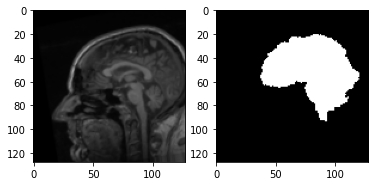

In [ ]:
import matplotlib.pyplot as plt

images, masks = next(joined_generator_x)

fig = plt.figure()

fig.add_subplot(1,2,1)
plt.imshow(images[2])

fig.add_subplot(1,2,2)
plt.imshow(masks[2])


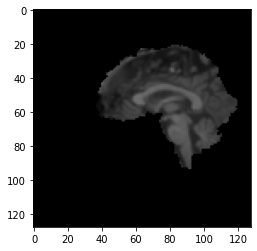

In [ ]:
image = images[2]
mask  = masks[2]

image[mask == 0] = 0 

plt.imshow(image)

### Basic Mdoels

####X axis

In [ ]:
datagen_params = dict(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.15
)

images_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    **datagen_params
)

masks_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_params
)

train_images_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training',
    interpolation='bilinear'
)

train_masks_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training'
)

val_images_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

val_masks_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

train_combined_generator_x = zip(train_images_generator_x, train_masks_generator_x)
val_combined_generator_x = zip(val_images_generator_x, val_masks_generator_x)

Found 329 images belonging to 1 classes.
Found 329 images belonging to 1 classes.
Found 57 images belonging to 1 classes.
Found 58 images belonging to 1 classes.


#### Y axis

In [ ]:
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/images_y/images_y
!mv /content/drive/MyDrive/Dane_ZPO/proj_brain/images_y/*.png /content/drive/MyDrive/Dane_ZPO/proj_brain/images_y/images_y

In [ ]:
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y/labels_y
!mv /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y/*.png /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y/labels_y

In [ ]:
train_images_generator_y = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_y',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training',
    interpolation='bilinear'
)

train_masks_generator_y = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training'
)

val_images_generator_y = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_y',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

val_masks_generator_y = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_y',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

train_combined_generator_y = zip(train_images_generator_y, train_masks_generator_y)
val_combined_generator_y = zip(val_images_generator_y, val_masks_generator_y)

Found 329 images belonging to 1 classes.
Found 329 images belonging to 1 classes.
Found 57 images belonging to 1 classes.
Found 58 images belonging to 1 classes.


#### Z axis

In [ ]:
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/images_z/images_z
!mv /content/drive/MyDrive/Dane_ZPO/proj_brain/images_z/*.png /content/drive/MyDrive/Dane_ZPO/proj_brain/images_z/images_z

In [ ]:
!mkdir /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z/labels_z
!mv /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z/*.png /content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z/labels_z

In [ ]:
train_images_generator_z = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_z',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training',
    interpolation='bilinear'
)

train_masks_generator_z = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training'
)

val_images_generator_z = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_z',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

val_masks_generator_z = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_z',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

train_combined_generator_z = zip(train_images_generator_z, train_masks_generator_z)
val_combined_generator_z = zip(val_images_generator_z, val_masks_generator_z)

Found 329 images belonging to 1 classes.
Found 329 images belonging to 1 classes.
Found 57 images belonging to 1 classes.
Found 58 images belonging to 1 classes.


In [21]:
from tensorflow import keras

custom_model_x = keras.Sequential([
  keras.layers.InputLayer(input_shape=(128,128,3)),

  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.MaxPool2D(),

  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
  keras.layers.UpSampling2D(),
  
  keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='relu')
])

In [ ]:
custom_model_x.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 256)     590080    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 256)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [ ]:
datagen_params = dict(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.15
)

images_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    **datagen_params
)

masks_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_params
)

train_images_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training',
    interpolation='bilinear'
)

train_masks_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='training'
)

val_images_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

val_masks_generator_x = images_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dane_ZPO/proj_brain/labels_x',
    target_size=(128, 128),
    batch_size=32,
    seed=42,
    class_mode=None,
    subset='validation'
)

train_combined_generator_x = zip(train_images_generator_x, train_masks_generator_x)
val_combined_generator_x = zip(val_images_generator_x, val_masks_generator_x)

Found 329 images belonging to 1 classes.
Found 329 images belonging to 1 classes.
Found 57 images belonging to 1 classes.
Found 58 images belonging to 1 classes.


In [ ]:
training_samples_x = train_images_generator_x.n
validation_samples_x = val_images_generator_x.n

custom_model_x.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
custom_model_x.fit(
    train_combined_generator_x,
    steps_per_epoch=training_samples_x // 32,
    validation_data=val_combined_generator_x,
    validation_steps=validation_samples_x // 64,
    epochs=20,
    verbose=1
)

Epoch 1/20
10/10 [==============================] - 30s 939ms/step - loss: 0.6289 - binary_accuracy: 0.7771
Epoch 2/20
10/10 [==============================] - 12s 903ms/step - loss: 0.4176 - binary_accuracy: 0.8120
Epoch 3/20
10/10 [==============================] - 8s 819ms/step - loss: 0.3975 - binary_accuracy: 0.8193
Epoch 4/20
10/10 [==============================] - 8s 815ms/step - loss: 0.5561 - binary_accuracy: 0.7816
Epoch 5/20
10/10 [==============================] - 8s 815ms/step - loss: 0.3649 - binary_accuracy: 0.8130
Epoch 6/20
10/10 [==============================] - 8s 842ms/step - loss: 0.3758 - binary_accuracy: 0.8628
Epoch 7/20
10/10 [==============================] - 8s 815ms/step - loss: 0.2519 - binary_accuracy: 0.8938
Epoch 8/20
10/10 [==============================] - 8s 813ms/step - loss: 0.2055 - binary_accuracy: 0.9021
Epoch 9/20
10/10 [==============================] - 8s 811ms/step - loss: 0.1701 - binary_accuracy: 0.9199
Epoch 10/20
10/10 [================

###EFFICIENT NET


In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 5.9 MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
from segmentation_models import Unet


ef_model_x = Unet('efficientnetb0', classes=1, activation='sigmoid',encoder_weights='imagenet')
ef_model_y = Unet('efficientnetb0', classes=1, activation='sigmoid',encoder_weights='imagenet')
ef_model_z = Unet('efficientnetb0', classes=1, activation='sigmoid',encoder_weights='imagenet')

Segmentation Models: using `tf.keras` framework.
16818176/16804768 [==============================] - 1s 0us/step


In [ ]:
ef_model_x.compile(
    optimizer=tf.keras.optimizers.Adam(lr=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

training_samples_x = train_images_generator_x.n
validation_samples_x = val_images_generator_x.n



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
ef_model_y.compile(
    optimizer=tf.keras.optimizers.Adam(lr=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

training_samples_y = train_images_generator_y.n
validation_samples_y = val_images_generator_y.n

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
ef_model_z.compile(
    optimizer=tf.keras.optimizers.Adam(lr=3e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

training_samples_z = train_images_generator_z.n
validation_samples_z = val_images_generator_z.n

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
ef_model_x.fit(
    train_combined_generator_x,
    steps_per_epoch=training_samples_x // 32,
    validation_data=val_combined_generator_x,
    validation_steps=validation_samples_x // 64,
    epochs=20,
    use_multiprocessing=True,
    workers=2,
    verbose=1
)

Epoch 1/20
10/10 [==============================] - 31s 497ms/step - loss: 0.5347 - binary_accuracy: 0.7235
Epoch 2/20
10/10 [==============================] - 6s 640ms/step - loss: 0.3547 - binary_accuracy: 0.8866
Epoch 3/20
10/10 [==============================] - 4s 392ms/step - loss: 0.2565 - binary_accuracy: 0.9493
Epoch 4/20
10/10 [==============================] - 4s 356ms/step - loss: 0.2099 - binary_accuracy: 0.9600
Epoch 5/20
10/10 [==============================] - 5s 554ms/step - loss: 0.1732 - binary_accuracy: 0.9655
Epoch 6/20
10/10 [==============================] - 5s 451ms/step - loss: 0.1588 - binary_accuracy: 0.9651
Epoch 7/20
10/10 [==============================] - 5s 539ms/step - loss: 0.1364 - binary_accuracy: 0.9678
Epoch 8/20
10/10 [==============================] - 5s 524ms/step - loss: 0.1233 - binary_accuracy: 0.9686
Epoch 9/20
10/10 [==============================] - 5s 486ms/step - loss: 0.1112 - binary_accuracy: 0.9693
Epoch 10/20
10/10 [=================

In [ ]:
ef_model_y.fit(
    train_combined_generator_y,
    steps_per_epoch=training_samples_y // 32,
    validation_data=val_combined_generator_y,
    validation_steps=validation_samples_y // 64,
    epochs=20,
    use_multiprocessing=True,
    workers=2,
    verbose=1
)

Epoch 1/20
10/10 [==============================] - 22s 621ms/step - loss: 0.4992 - binary_accuracy: 0.7689
Epoch 2/20
10/10 [==============================] - 4s 433ms/step - loss: 0.3289 - binary_accuracy: 0.9102
Epoch 3/20
10/10 [==============================] - 5s 494ms/step - loss: 0.2377 - binary_accuracy: 0.9611
Epoch 4/20
10/10 [==============================] - 5s 514ms/step - loss: 0.1899 - binary_accuracy: 0.9698
Epoch 5/20
10/10 [==============================] - 4s 432ms/step - loss: 0.1533 - binary_accuracy: 0.9728
Epoch 6/20
10/10 [==============================] - 5s 502ms/step - loss: 0.1307 - binary_accuracy: 0.9731
Epoch 7/20
10/10 [==============================] - 5s 448ms/step - loss: 0.1137 - binary_accuracy: 0.9739
Epoch 8/20
10/10 [==============================] - 5s 524ms/step - loss: 0.0994 - binary_accuracy: 0.9748
Epoch 9/20
10/10 [==============================] - 5s 467ms/step - loss: 0.0922 - binary_accuracy: 0.9742
Epoch 10/20
10/10 [=================

In [ ]:
ef_model_z.fit(
    train_combined_generator_z,
    steps_per_epoch=training_samples_z // 32,
    validation_data=val_combined_generator_z,
    validation_steps=validation_samples_z // 64,
    epochs=20,
    use_multiprocessing=True,
    workers=2,
    verbose=1
)

Epoch 1/20
10/10 [==============================] - 22s 641ms/step - loss: 0.5891 - binary_accuracy: 0.7485
Epoch 2/20
10/10 [==============================] - 4s 457ms/step - loss: 0.3927 - binary_accuracy: 0.8889
Epoch 3/20
10/10 [==============================] - 5s 492ms/step - loss: 0.2798 - binary_accuracy: 0.9482
Epoch 4/20
10/10 [==============================] - 5s 500ms/step - loss: 0.2318 - binary_accuracy: 0.9597
Epoch 5/20
10/10 [==============================] - 4s 428ms/step - loss: 0.1953 - binary_accuracy: 0.9644
Epoch 6/20
10/10 [==============================] - 5s 517ms/step - loss: 0.1688 - binary_accuracy: 0.9669
Epoch 7/20
10/10 [==============================] - 5s 432ms/step - loss: 0.1510 - binary_accuracy: 0.9661
Epoch 8/20
10/10 [==============================] - 5s 514ms/step - loss: 0.1332 - binary_accuracy: 0.9682
Epoch 9/20
10/10 [==============================] - 5s 444ms/step - loss: 0.1205 - binary_accuracy: 0.9676
Epoch 10/20
10/10 [=================

In [ ]:
ef_model_x.save('/content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_x')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_x/assets


In [ ]:
ef_model_y.save('/content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_y')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_y/assets


In [ ]:
ef_model_z.save('/content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_z')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_z/assets


In [ ]:
ef_model_x.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                           

In [22]:
test_model = keras.models.load_model('/content/drive/MyDrive/Dane_ZPO/proj_brain/ef_model_x')

In [23]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 stem_conv (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 stem_bn (BatchNormalization)   (None, None, None,   128         ['stem_conv[0][0]']              
                                32)                                                           

The physical sizes of the voxels are similar - we are unlikely to need to do anything about differences of 0.2 - 0.3 mm. An alternative would be to use, for example, the `zoom` function from the `scipy` library (note - it is slow). The differences present here may even paradoxically improve the generalization of the network.

At this stage, you need to split the data (most likely the paths to it after loading its list in Python) into a training set and a validation set, and then export the split data into two-dimensional images - preferably in lossless PNG format.

The suggestion is to split the training and validation set already in the exported data on disk, but it can of course be implemented while loading the data paths for learning in the source code. We encourage you to experiment, but note that it is usually better to transfer entire scans rather than random cross sections to the validation set. Transferring random cross-sections causes the network to be validated on a fragment of a scan whose other fragments are in the training set - we have worse overshoot control, but on the other hand the network "sees" more different scans during training.

When exporting, you will need to navigate through both datasets, load more scans into memory (as above, but using the included load functions), and then export the data in the selected axis. It is a good idea to place a copy of the exported data on a mounted Google Drive. If the Colaba session expires, this will allow the data to be copied later to the target machine without repeating the export process.

Once the data is exported, you can use the approach known from the segmentation manual. Different cross-sections of the data can be tested (the final approach does not have to be one network at all - models can be taught for each cross-section), different neural network models (including with and without pretraining), different loss functions, different learning rates, different augmentations, different types of data normalization, etc.

Once the final model is trained, predictions can be generated for the test set. Below is a general example of generating predictions.




In [24]:
predictions_base_path = Path('/content/Predictions')
first_dataset_predictions_path = predictions_base_path / 'first'
second_dataset_predictions_path = predictions_base_path / 'second'

first_dataset_predictions_path.mkdir(exist_ok=True, parents=True)
second_dataset_predictions_path.mkdir(exist_ok=True, parents=True)

In [18]:
!mkdir tmp

In [26]:
first_dataset_test_path = Path('/content/FirstDataset/test')
second_dataset_test_path = Path('/content/SecondDataset/test')

for scan_path in first_dataset_test_path.iterdir():
  data, affine = load_raw_volume(scan_path)
  labels = np.zeros(data.shape, dtype=np.uint8)

  # Here you need to spell out, for example, one of the axes, make a prediction for each cross section and enter the labels into the matrix
  # NOTE - the mask should only contain the values 0 and 1
  # NOTE - the predictions are floating point numbers in the range 0 to 1 - they need to be binarized with a threshold (for example 0.5)
  
  # Example for the 'x' axis:
  x_size, y_size, z_size = data.shape
  for x_index in range(x_size):
    # print(x_index)
    data_slice = data[x_index, :, :]
    slice_x, slice_y = data_slice.shape
    plt.imsave('/content/tmp/tmp_x.png', data_slice, cmap="gray")   
    data_slice = cv2.imread('/content/tmp/tmp_x.png')
    data_slice = cv2.resize(data_slice, (128,128)).astype(np.float32) /255
    prediction = test_model.predict(data_slice[np.newaxis, :]).squeeze()
    prediction = cv2.resize(prediction, (slice_y, slice_x)).astype(np.float32)
    prediction[prediction > 0.5] = 1
    prediction[prediction < 0.5] = 0
    labels[x_index, :, :] = prediction
  
  save_labels(labels, affine, first_dataset_predictions_path / scan_path.name)

for scan_path in second_dataset_test_path.iterdir():
  data, affine = load_raw_volume(scan_path / 'T1w.nii.gz')
  labels = np.zeros(data.shape, dtype=np.uint8)

  # Here you need to spell out, for example, one of the axes, make a prediction for each cross section and enter the labels into the matrix
  # NOTE - the mask should only contain the values 0 and 1
  # NOTE - the predictions are floating point numbers in the range 0 to 1 - they need to be binarized with a threshold (for example 0.5)

  # Example for the 'x' axis:
  x_size, y_size, z_size = data.shape
  for x_index in range(x_size):
    # print(x_index)
    data_slice = data[x_index, :, :]
    slice_x, slice_y = data_slice.shape
    plt.imsave('/content/tmp/tmp_x.png', data_slice, cmap="gray")   
    data_slice = cv2.imread('/content/tmp/tmp_x.png')
    data_slice = cv2.resize(data_slice, (128,128)).astype(np.float32) /255
    prediction = test_model.predict(data_slice[np.newaxis, :]).squeeze()
    prediction = cv2.resize(prediction, (slice_y, slice_x)).astype(np.float32)
    prediction[prediction > 0.5] = 1
    prediction[prediction < 0.5] = 0
    labels[x_index, :, :] = prediction
  
  save_labels(labels, affine, second_dataset_predictions_path / f'{scan_path.name}.nii.gz')

In [28]:
!cp -r /content/Predictions /content/drive/MyDrive/Dane_ZPO

The `Predictions` folder prepared in this way should be uploaded to the Moodle system for assessment.

The prepared predictions can be further verified using the checker available on the public server. Below is the sample code that displays the metrics for the test set.

In [ ]:
import requests
import zlib

for dataset_predictions_path in (first_dataset_predictions_path, second_dataset_predictions_path):
  for prediction_path in dataset_predictions_path.iterdir():
    prediction_name = prediction_path.name[:-7]  # Remove '.nii.gz' from file name
    print(prediction_name)
    prediction = nib.load(str(prediction_path))

    response = requests.post(f'https://zpo.dpieczynski.pl/{prediction_name}', data=zlib.compress(prediction.to_bytes()))
    if response.status_code == 200:
        print(dataset_predictions_path.name, prediction_path.name, response.json())
    else:
        print(f'Error processing prediction {dataset_predictions_path.name}/{prediction_name}: {response.text}')

A test to check performance on single images

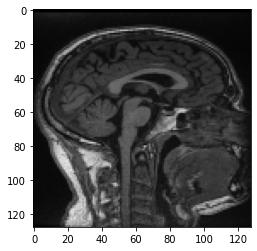

In [37]:
import cv2
import numpy as np

image = cv2.imread('/content/drive/MyDrive/Dane_ZPO/proj_brain/images_x/011e40c2b1d3c9bb53bd9e5a7efd04ba_x.png')
image = cv2.resize(image, (128,128)).astype(np.float32) /255
plt.imshow(image)

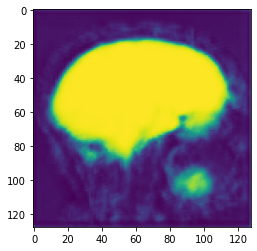

In [38]:
mask = test_model.predict(image[np.newaxis, :]).squeeze()
plt.imshow(mask.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


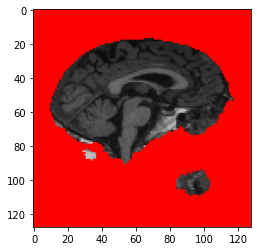

In [39]:
image[mask < 0.5] = (255, 0, 0)
plt.imshow(image)